Ensuring gpu is being used, if available, and proper backend is used.

In [2]:
import platform
import os

# Check operating system
is_macos = platform.system() == 'Darwin'

if is_macos:
    # For MacOS, use TensorFlow backend
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    import tensorflow as tf
    print("Using TensorFlow backend on MacOS")
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
else:
    # For other OS, use PyTorch backend
    os.environ['KERAS_BACKEND'] = 'torch'
    import torch
    print("Using PyTorch backend")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cpu


Loading all necessary libraries.

In [144]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from itertools import product
import json 

from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import L2
from keras.src.saving import load_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import string

from wordcloud import WordCloud, STOPWORDS

Loading, cleaning, and visualizing the data

In [79]:
# datasets do not have header so setting it manually
train_data = pd.read_csv('data/twitter-2016train-A.txt', sep = '\t', header = None, names = ['id', 'label', 'text'])
test_data = pd.read_csv('data/twitter-2016test-A.txt', sep = '\t', header = None, names = ['id', 'label', 'text', 'nan'])

In [81]:
# defining the Ekphrasis preprocessor
text_processor = TextPreProcessor(normalize = ['url', 'email', 'phone', 'user', 'time', 'date', 'number', 'money', 'hashtag', 'percent'],
                                  annotate = {'hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'},
                                  fix_text = True, spell_correct_path = None, 
                                  tokenizer = SocialTokenizer(lowercase = True).tokenize, dicts = [emoticons])

def preprocess_func(text):
    if pd.isna(text):
        return ""
    return " ".join(text_processor.pre_process_doc(str(text)))

c:\Users\owenh\OneDrive\Documents\Northwestern Stuff\Academic Year 4 2025-26\01 - Fall 2025\STAT 362\STAT_362_Final_Project\.venv\Lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
You can't omit/backoff and unpack hashtags!
 unpack_hashtags will be set to False


c:\Users\owenh\OneDrive\Documents\Northwestern Stuff\Academic Year 4 2025-26\01 - Fall 2025\STAT 362\STAT_362_Final_Project\.venv\Lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [82]:
# applying text preprocessing
train_data['processed_text'] = train_data['text'].apply(preprocess_func)
test_data['processed_text'] = test_data['text'].apply(preprocess_func)

# getting the data as lists for encoding and tokenization
train_processed_text = train_data['processed_text'].values.tolist()
train_labels = train_data['label'].values.tolist()

test_processed_text = test_data['processed_text'].values.tolist()
test_labels = test_data['label'].values.tolist()

In [83]:
# creating a dictionary of all of the words in each label type of the training data
sentiment_text_map = {}
grouped_text_df = train_data.groupby('label') # grouping by label to achieve it
for label_class, group in grouped_text_df:
    sentiment_text_map[label_class] = ' '.join(group['processed_text'].values.tolist())

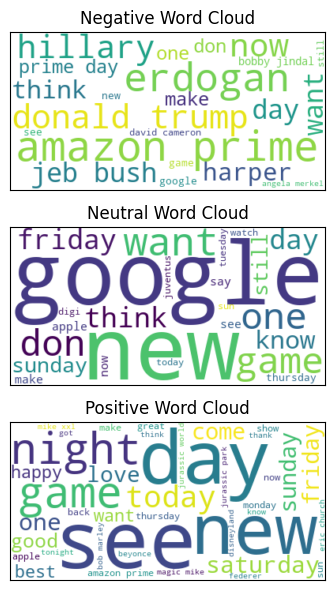

In [84]:
# setting up figure to plot the wordclouds
fig, axs = plt.subplots(3, 1, figsize = (18, 6))
axs = axs.flatten()
# setting titles of each subplot
titles = {'positive': 'Positive Word Cloud', 'negative': 'Negative Word Cloud', 'neutral': 'Neutral Word Cloud'}
# going through each label type
for i, (sentiment, text) in enumerate(sentiment_text_map.items()):
    # removing the same words from each processed string, mostly removing processed additions
    words_to_filter = ['<url>', '<user>', '<hashtag>', '</hashtag>', '<allcaps>', '</allcaps>', 
        '<repeated>', '</repeated>', 'number', 'time', 'date', 'money', 'percent', 'may', 'will', 'tomorrow', 'going']
    cleaned_text = text
    for word in words_to_filter:
        cleaned_text = re.sub(re.escape(word), ' ', cleaned_text, flags = re.IGNORECASE)
    # generating custom stopwords to add to the standard, all combinations of one and two letters to account for common typos/meaningless tweet components
    custom_stopwords = set(STOPWORDS)
    letters = string.ascii_lowercase
    single_letters = list(letters)
    two_letter_combos = [''.join(p) for p in product(letters, repeat = 2)]
    custom_stopwords.update(single_letters + two_letter_combos)
    # generating the word cloud
    wordcloud = WordCloud(stopwords = custom_stopwords, max_words = 50, min_font_size = 10, background_color = 'white').generate(cleaned_text)
    # plotting the wordcloud in the appropriate subplot
    ax = axs[i]
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.set_title(titles[sentiment])
    ax.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
    ax.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
# showing the plot
plt.tight_layout()
plt.show()

Encoding, Tokenizing, and Vocabulary

In [ ]:
# encoding labels to work with keras
label_map = {'negative': -1, 'neutral': 0, 'positive': 1}
target_names = ['negative', 'neutral', 'positive'] # for later use

# converting labels to int, then using keras to_categorical
train_labels_int = np.array([label_map[x] for x in train_labels])
train_y = to_categorical(train_labels_int, num_classes = 3)

test_labels_int = np.array([label_map[x] for x in test_labels])
test_y = to_categorical(test_labels_int, num_classes = 3)

In [86]:
# Tokenizing
# using ekphrasis tokenizer again for consistency
tokenizer = SocialTokenizer(lowercase = True)

train_tokenized = [tokenizer.tokenize(x) for x in train_processed_text]
test_tokenized = [tokenizer.tokenize(x) for x in test_processed_text]

In [88]:
# Vocabulary
# initializing dictionary to store vocab
word_index = {}
current_index = 1 # ensuring 0 is preserved for unkown words
train_int_sequences = []

# going through each tokenized message in the training set to convert it to vector and store words in dictionary
for message in train_tokenized:
    # vector to add to train_int_sequencs
    vector = []
    # going through each word in the message
    for word in message:
        if word not in word_index: # storing word in dictionary in a new index
            word_index[word] = current_index
            current_index += 1
        # adding dictionary entry of word to the message vector
        vector.append(word_index[word])
    # adding message vector to train int sequence
    train_int_sequences.append(vector)

vocab_size = current_index # storing the number of unique words in the training set as the vocab size for later

# for the test data, using the dictionary and subbing 0 as an index for an unseen word
test_int_sequences = []
for message in test_tokenized:
    vector = [word_index.get(word, 0) for word in message]
    test_int_sequences.append(vector)

In [102]:
# getting the length of every message
training_message_len = [len(vector) for vector in train_int_sequences]
# calculating 99.5th percentile of length
percentile_995 = np.percentile(training_message_len, 99.5)
max_sequence_length = int(np.ceil(percentile_995)) # rounding up
print(f'99.5th percentile message length is {max_sequence_length} words.')

99.5th percentile message length is 40 words.


In [103]:
# padding the vectors 
train_x = pad_sequences(train_int_sequences, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
test_x = pad_sequences(test_int_sequences, maxlen = max_sequence_length, padding = 'post', truncating = 'post')

Defining the model

In [104]:
# getting validation set from training data
train_x_split, val_x, train_y_split, val_y = train_test_split(train_x, train_y, test_size = 0.15, stratify = train_y)

In [ ]:
# defining the model in line with https://aclanthology.org/S17-2126.pdf 
def lstm_model():
    # initializing embedding matrix to the dimensions of the embedding (paper set it at 300, reduced which seemed to help with overfitting somewhat) and vocab size, 
    embedding_matrix = np.random.uniform(-0.5, 0.5, (vocab_size, 100))
    # defining input, vector of size 40 or max_sequence_length of integers
    sequence_input = Input(shape = (max_sequence_length,), dtype = 'int32')
    # defining the embedding layer and passing the sequence input - paper has output_dim of 300, changed to match embedding matrix
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = 100, weights = [embedding_matrix], 
                                trainable = True, mask_zero = True)
    embedded_sequences = embedding_layer(sequence_input)
    # adding drop out layer between embedding and lstms, basing dropout rate on paper (increased from 0.3)
    x = Dropout(0.3)(embedded_sequences)
    # passing through two bidirectional lstm layers with hyperparameters in line with the paper, reduced the LSTM layers from 150 to simplify the model to try and help with overfitting
    lstm1 = Bidirectional(LSTM(100, return_sequences = True, dropout = 0.5, recurrent_dropout = 0.25), name = 'bilstm1')(x)
    lstm2 = Bidirectional(LSTM(100, return_sequences = False, dropout = 0.5, recurrent_dropout = 0.25), name = 'bilstm2')(lstm1)
    # skipping the attention layer, as the paper only found it had a small effect
    # using a dense layer with soft max and l2 regularization to make classification, increased l2 from 0.0001 to 0.005 to increase regularization
    preds = Dense(3, activation = 'softmax', kernel_regularizer = L2(0.005))(lstm2)
    # returning the full model
    model = Model(sequence_input, preds)
    return model

Training the model

In [147]:
# if the model has already been trained then load it and the history to save time
if os.path.exists('data/best_sentiment_model.kers'): # if model needs to be retrained, just alter file path slightly and then change back
    model = load_model('data/best_sentiment_model.keras')
else:
    # using the defined model and compiling with adam optimizer in line with the paper
    model = lstm_model()
    optimizer = Adam(learning_rate = 0.00025)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    # defining early stopping and ensuring the best model is saved
    callbacks_list = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3, verbose = 1, restore_best_weights = True),
                     ModelCheckpoint(filepath = 'data/best_sentiment_model.keras', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)]
    # fitting the model, batch size in line with the paper
    history = model.fit(train_x_split, train_y_split, batch_size = 128, epochs = 20, verbose = 1, 
                        validation_data = (val_x, val_y), callbacks = callbacks_list)

    # saving the history dictionary
    with open('data/best_sentiment_model_history.json', 'w') as f:
            json.dump(history.history, f)

    # Close device scope if using TensorFlow
    if is_macos and os.environ['KERAS_BACKEND'] == 'tensorflow':
        tf.__exit__(None, None, None)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4072 - loss: 1.1051
Epoch 1: val_loss improved from None to 1.01353, saving model to data/best_sentiment_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4562 - loss: 1.0796 - val_accuracy: 0.5142 - val_loss: 1.0135
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5162 - loss: 1.0168
Epoch 2: val_loss improved from 1.01353 to 0.99777, saving model to data/best_sentiment_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5167 - loss: 1.0151 - val_accuracy: 0.5142 - val_loss: 0.9978
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5258 - loss: 1.0064
Epoch 3: val_loss improved from 0.99777 to 0.98457, saving model to data/best_sentiment_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5242 - loss: 1.0011 - val_accuracy: 0.5244 - val_loss: 0.9846
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5370 - loss: 0.9847
Epoch 4: val_loss improved

Analyzing Model Performance

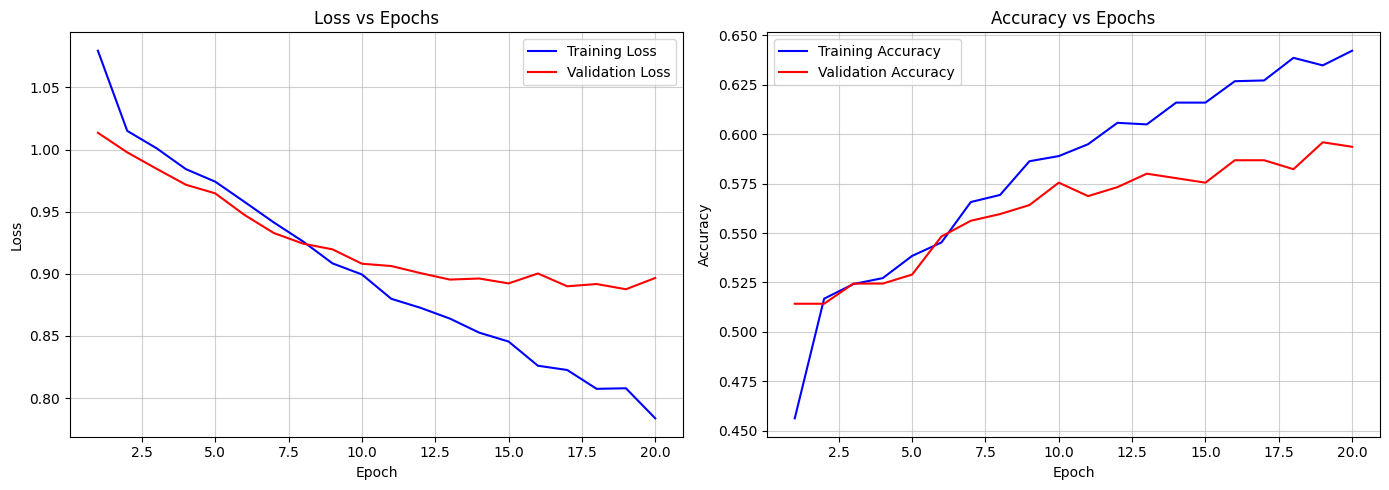

In [148]:
# plotting training history
if os.path.exists('data/best_sentiment_model_history.json'):
        with open('data/best_sentiment_model_history.json', 'r') as f:
            history_dict = json.load(f)
# creating subplots
fig, axs = plt.subplots(1, 2, figsize = (14, 5))
num_epochs = range(1, len(history_dict['loss']) + 1) # number of training epochs
# plotting loss
axs[0].plot(num_epochs, history_dict['loss'], label = 'Training Loss', color = 'blue')
axs[0].plot(num_epochs, history_dict['val_loss'], label = 'Validation Loss', color = 'red')
axs[0].set_title('Loss vs Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True, alpha = 0.6)
# plotting accuracy 
axs[1].plot(num_epochs, history_dict['accuracy'], label = 'Training Accuracy', color = 'blue')
axs[1].plot(num_epochs, history_dict['val_accuracy'], label = 'Validation Accuracy', color = 'red')
axs[1].set_title('Accuracy vs Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True, alpha = 0.6)

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

    negative       0.60      0.41      0.49     10342
     neutral       0.44      0.80      0.57      7059
    positive       0.40      0.09      0.14      3231

    accuracy                           0.50     20632
   macro avg       0.48      0.43      0.40     20632
weighted avg       0.51      0.50      0.46     20632

The paper's model was 0.243466509125502 higher in average recall then this models average recall of 0.43453349087449805
The paper's model was 0.3573988378142482 higher in average F1 score over the positive and negative classes than this model's 0.31560116218575185


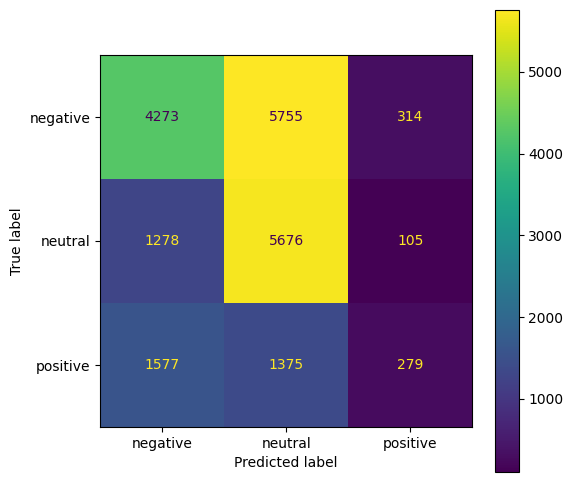

In [149]:
# evaluating performance on test set
test_y_pred = model.predict(test_x, verbose = 0)
# converting to class labels
test_y_pred_class = np.argmax(test_y_pred, axis = 1)
test_y_true_class = np.argmax(test_y, axis = 1)
# printing classificaiton report
print(classification_report(test_y_true_class, test_y_pred_class, target_names = target_names, zero_division = 0))

# comparing to paper model
report_dict = classification_report(test_y_true_class, test_y_pred_class, target_names = target_names, zero_division = 0, output_dict = True)
avg_recall = report_dict['macro avg']['recall']
maf1_pos_neg = (report_dict['positive']['f1-score'] + report_dict['negative']['f1-score']) / 2
print(f'The paper\'s model was {0.678 - avg_recall} higher in average recall then this models average recall of {avg_recall}')
print(f'The paper\'s model was {0.673 - maf1_pos_neg} higher in average F1 score over the positive and negative classes than this model\'s {maf1_pos_neg}')

disp = ConfusionMatrixDisplay.from_predictions(test_y_true_class, test_y_pred_class, display_labels = target_names)
disp.figure_.set_size_inches(6, 6)
plt.show()


Even with many hours of tuning the hyperparametes, accuracy, recall, and F1 score stay around the same. I chose these hyperparameters because they performed close to the best when it comes to positive comments while being in an acceptable range for recall and F1 score (given the constraints of this model). To achieve results comparable to Baziotis et al. I believe the tokenizaiton would require significant reworking. They had a far more robust text preprocessing system as well as pre-trained word embeddings. 